In [237]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.utils as tutils
from torchvision import datasets
from torchvision import transforms
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch
import torchvision

In [238]:
h5 = h5py.File('paths/data_1.h5', 'r')
h5.keys()

[u'FinalLoss',
 u'Height',
 u'Image',
 u'Lighting',
 u'Normal',
 u'Reflectance',
 u'Shading',
 u'TrueNormal',
 u'mask',
 u'trueLighting']

In [273]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    

class CustomDataSetLoader(Dataset):
    def __init__(self, inData, transform = None):
        self.data = inData
        self.transform = transform
        #normalize here or in __getitem__

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        data = data.permute(1, 2, 0)
        return data

    def __len__(self):
        return len(self.data)
    
class DataSetNoPermute(Dataset):
    def __init__(self, inData, transform = None):
        self.data = inData
        self.transform = transform
        #normalize here or in __getitem__

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        data = data.permute(0, 2, 1)
        return data

    def __len__(self):
        return len(self.data)

def get_h5_file_names(path):
    h5Files = []
    for file in os.listdir(path):
        h5Files.append(path+file)
    return h5Files

def load_SfSNet_data(path, validation = False, batch_size = 64):
    h5Files = get_h5_file_names(path)
    if len(h5Files) == 0:
        print('NO H5 FILE FOUND FOR SYNTHETIC IMAGES', 'WARNING')
        return None

    # Load data from H5 Files
    firstTime = True
    for file in h5Files:
        hf = h5py.File(file, 'r')
        print hf.keys()
        rImg1 = hf['/Image']
        lighting1 = hf['/Lighting']
        normal1 = hf['/Normal']
        shading1 = hf['/Shading']
        true_normal1 = hf['/TrueNormal']
        mask1 = hf['/mask']
        true_lighting1 = hf['/trueLighting']
        # Following are not need for current experiment
        # PLEASE UNCOMMENT IF YOU NEED
        # height = hf['/Height']
        # reflectance = hf['/Reflectance']
        # finalLoss = hf['/FinalLoss']
        if firstTime:
            rImage = np.array(rImg1[:,:,:])
            lighting = np.array(lighting1[:,:])
            normal = np.array(normal1[:,:,:])
            shading = np.array(shading1[:,:,:])
            true_normal = np.array(true_normal1[:,:,:])
            mask = np.array(mask1[:,:,:])
            true_lighting = np.array(true_lighting1[:,:])
            firstTime = False
        else:
            rImage = np.concatenate((rImg, np.array(rImg1[:,:,:])))
            lighting = np.concatenate((lighting, np.array(lighting1[:,:])))
            normal = np.concatenate((normal, np.array(normal1[:,:,:])))
            shading = np.concatenate((shading, np.array(shading1[:,:,:])))
            true_normal = np.concatenate((true_normal, np.array(true_normal1[:,:,:])))
            mask = np.concatenate((mask, np.array(mask1[:,:,:])))
            true_lighting = np.concatenate((true_lighting, np.array(true_lighting1[:,:])))

    print('Size of Real data: ', rImage.shape, mask.shape, true_normal.shape)
    # Transforms being used
    transform = transforms.Compose([
            #transforms.Resize(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    noNormalize = transforms.Compose([
            #transforms.Resize(),
            transforms.ToTensor(),
    ])
        
    if validation:
        rImage_val, rImage = np.split(rImage, [batch_size])
        lighting_val, lighting = np.split(lighting, [batch_size])
        normal_val, normal = np.split(normal, [batch_size])
        shading_val, shading = np.split(shading, [batch_size])
        true_normal_val, true_normal = np.split(true_normal, [batch_size])
        mask_val, mask = np.split(mask, [batch_size])
        true_lighting_val, true_lighting = np.split(true_lighting, [batch_size])
        
        rImage_val = CustomDataSetLoader(rImage_val, transform = transform)

        real_image_val = torch.utils.data.DataLoader(rImage_val, batch_size= batch_size, shuffle = False)
        sirfs_sh_val = torch.utils.data.DataLoader(lighting_val, batch_size= batch_size, shuffle = False)
        sirfs_normal_val = torch.utils.data.DataLoader(normal_val, batch_size= batch_size, shuffle = False)
        sirfs_shading_val = torch.utils.data.DataLoader(shading_val, batch_size= batch_size, shuffle = False)
        true_normal_val = torch.utils.data.DataLoader(true_normal_val, batch_size= batch_size, shuffle = False)
        mask_val = torch.utils.data.DataLoader(mask_val, batch_size= batch_size, shuffle = False)
        true_lighting_val = torch.utils.data.DataLoader(true_lighting_val, batch_size= batch_size, shuffle = False)

    else:
        real_image_val = None
        sirfs_sh_val = None
        sirfs_normal_val = None
        sirfs_shading_val = None
        true_normal_val = None
        mask_val = None
        true_lighting_val = None
                                     
    # Custom image dataset
    # Normal and Shading is already normalized by SIRFS method
    # So, Normalize only real images
    rImage = CustomDataSetLoader(rImage, transform = transform)
    mask = DataSetNoPermute(mask, transform = noNormalize)
    true_normal = CustomDataSetLoader(true_normal, transform = noNormalize)

    realImage = torch.utils.data.DataLoader(rImage, batch_size= batch_size, shuffle = False)
    realSH = torch.utils.data.DataLoader(lighting, batch_size= batch_size, shuffle = False)
    rNormal = torch.utils.data.DataLoader(normal, batch_size= batch_size, shuffle = False)
    rShading = torch.utils.data.DataLoader(shading, batch_size= batch_size, shuffle = False)
    tNormal = torch.utils.data.DataLoader(true_normal, batch_size= batch_size, shuffle = False)
    mask = torch.utils.data.DataLoader(mask, batch_size= batch_size, shuffle = False)
    tSH = torch.utils.data.DataLoader(true_lighting, batch_size= batch_size, shuffle = False)
    
    print('Loading SFSNet Synthetic Images Completed')
    # Following are not need for current experiment
    # PLEASE UNCOMMENT IF YOU NEED
    # rHeight = torch.utils.data.DataLoader(height, batch_size= batch_size, shuffle = False)
    # rReflectance = torch.utils.data.DataLoader(reflectance, batch_size= batch_size, shuffle = False)
    # rFinalLoss = torch.utils.data.DataLoader(finalLoss, batch_size= batch_size, shuffle = False)
    return realImage, rNormal, realSH, rShading, tNormal, mask, tSH, real_image_val, sirfs_sh_val, sirfs_normal_val, sirfs_shading_val, true_normal_val, mask_val, true_lighting_val 



In [274]:
realImage, rNormal, realSH, rShading, tNormal, mask, tSH, real_image_val, sirfs_sh_val, sirfs_normal_val, sirfs_shading_val, true_normal_val, mask_val, true_lighting_val = load_SfSNet_data('./paths/')

[u'FinalLoss', u'Height', u'Image', u'Lighting', u'Normal', u'Reflectance', u'Shading', u'TrueNormal', u'mask', u'trueLighting']
('Size of Real data: ', (300, 3, 64, 64), (300, 64, 64, 3), (300, 3, 64, 64))
Loading SFSNet Synthetic Images Completed


In [275]:
# plt.imshow(mask[10], interpolation='nearest')
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

torch.Size([64, 3, 64, 64])


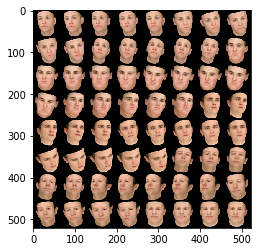

In [276]:
dreal = next(iter(realImage))
print(dreal.size())
show(torchvision.utils.make_grid(dreal, padding=1))

torch.Size([64, 3, 64, 64])


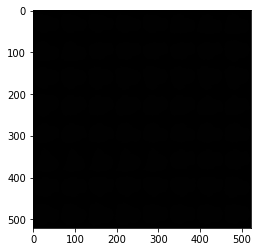

In [277]:
mk = next(iter(mask))
print(mk.size())
show(torchvision.utils.make_grid(mk, padding=1))
#plt.imshow(torchvision.utils.make_grid(dreal, padding=1), interpolation='nearest')

In [271]:
ans = torch.mul(dreal, mk)

/home/bhushan/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  """Entry point for launching an IPython kernel.


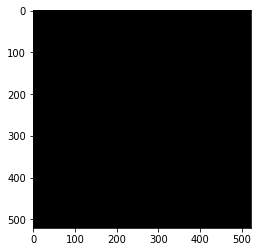

In [272]:
show(torchvision.utils.make_grid(ans, padding=1))

torch.Size([64, 64, 3])


TypeError: Invalid dimensions for image data

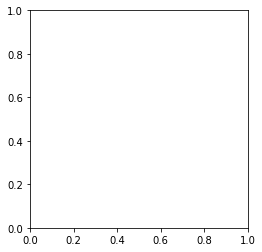

In [221]:
print(mk[10].shape)
#plt.imshow(dreal[10], interpolation='nearest')
show(mk[10])

torch.Size([64, 3, 64, 64])


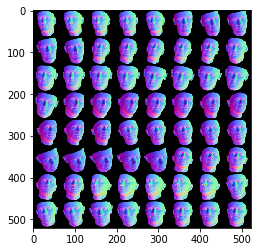

In [227]:
normal = next(iter(tNormal))
print(normal.size())
show(torchvision.utils.make_grid(normal, padding=1))

In [228]:
tsh = next(iter(tSH))
print(tsh.size())
#show(torchvision.utils.make_grid(normal, padding=1))

torch.Size([64, 27])


torch.Size([3, 64, 64])


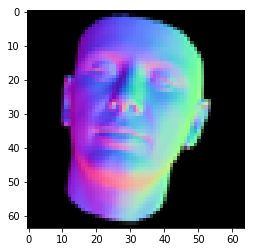

In [199]:
print(dreal[10].shape)
#plt.imshow(dreal[10], interpolation='nearest')
show(dreal[10])

In [254]:
mask = h5['mask']

In [255]:
print(h5['mask'][10].shape)

(64, 64, 3)


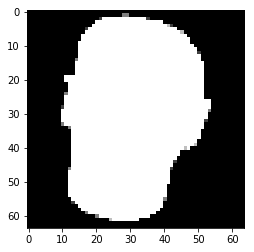

In [257]:
#plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
h5 = h5py.File('paths/data_1.h5', 'r')
plt.imshow(h5['mask'][10], interpolation='nearest')

In [86]:
sh = h5['trueLighting']

In [87]:
sh.shape

(300, 27)

In [20]:
sh[0]

array([ 0.300794,  0.121209, -0.115402,  0.073493, -0.126265, -0.035606,
        0.013735, -0.018538, -0.055469,  0.202293,  0.105253, -0.058834,
        0.047335, -0.097811, -0.032969,  0.010878, -0.024713, -0.028035,
        0.150027,  0.096441, -0.049527,  0.032507, -0.088273, -0.033228,
        0.007316, -0.015788, -0.021543])

In [226]:
from shading import *

In [235]:
outShadingB = ShadingFromDataLoading(tNormal, tSH) #, shadingFromNet = True)
#outShadingB = denorm(outShadingB)
#outShadingB = applyMask(outShadingB, real_image_mask)
outShadingB = outShadingB.data
pic = torchvision.utils.make_grid(outShadingB, padding=1)


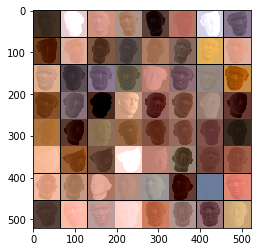

In [236]:
show(pic)